# Экспоненциальные интеграторы
## Тесты и бенчмарки

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import os
import pandas as pd
import numpy as np
import scipy.linalg as spl
import scipy.optimize as sopt

In [3]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)

In [4]:
plot_loss_ = False

In [5]:
def diam(X):
    max_norm = 0.0
    for index in range(len(X)):
        for jndex in range(index + 1, len(X)):
            max_norm = max(max_norm, np.linalg.norm(X[index] - X[jndex]))
            
    return max_norm

In [6]:
def plot_Newton(X, F, args, padding=1.5, N_grid=100, abs_eps=1e-8, rel_eps=1e-8):
    X = np.array(X)
    
    x_min = np.min(X[:,0]) - padding
    x_max = np.max(X[:,0]) + padding
    y_min = np.min(X[:,1]) - padding
    y_max = np.max(X[:,1]) + padding
    
    x = np.array([x_min + x_max, y_min + y_max]) / 2.0
    Delta = max(x_max - x_min, y_max - y_min) / 2.0
    
    image_X = (X - x + Delta) * N_grid / (2.0 * Delta)
    
    grid_1 = np.linspace(x[0] - Delta, x[0] + Delta, N_grid)
    grid_2 = np.linspace(x[1] - Delta, x[1] + Delta, N_grid)

    values = np.array([[np.linalg.norm(F(np.array([grid_1[x], grid_2[y]]), *args)) for x in range(N_grid)] for y in range(N_grid)])
    #levels = np.logspace(np.log10(max(np.min(values), abs_eps)), np.log10(max(np.max(values), abs_eps)), 10)
    #levels = np.linspace(np.min(values), np.max(values), 32)
    power = 4.0
    levels = np.power(np.linspace(np.power(np.min(values), 1.0 / power), np.power(np.max(values), 1.0 / power), 16), power)
        
    fig, ax = plt.subplots()
    ax.axis('off')

    fig.set_figheight(8)
    fig.set_figwidth(8)
        
    #ax.imshow(values)
    ax.contour(values, levels, linewidths=2, cmap='gist_rainbow', alpha=1.0, origin='lower')
    ax.plot(image_X[:,0], image_X[:,1],
            color='black',
            #cmap='rainbow',
            linewidth=4,
            marker='.',
            markersize=16, markeredgewidth=1)
       
    plt.show()
    
    return

In [7]:
def Newton_method(x_0, F, der_F, args=(), abs_eps=1e-7, rel_eps=1e-9, max_iters=200, mu=1.0, verbose=0):
    """
    Метод Ньютона для уравнения F(x) = 0.
    """
    
    m = 0
    error = 0.0
    x = x_0.copy()
    X = [x_0]
    F_0_norm = np.linalg.norm(F(x, *args))
    while m < max_iters:
        r = F(x, *args)
        M = der_F(x, *args)
        x -= mu * np.linalg.solve(M, r)
        
        if verbose > 1:
            print("iter: %d" % m)
            print("x: ", x)
        
        F_m = F(x, *args)
        error = np.linalg.norm(F_m)
        if error < max(abs_eps, rel_eps * F_0_norm):
            break
            
        m += 1
        X.append(x.copy())
    
    if m == max_iters:
        print("Max iters, error: %.3e" % error)
    
    # График области.
    if plot_loss_:
        plot_Newton(X, F, args, abs_eps=abs_eps, rel_eps=rel_eps)
        
    return x, m

In [8]:
def phi_element(x, eps_min, eps_max):
    if np.abs(x) < eps_min:
        return 0.5 - x / 12.0
    else:
        return 1.0 / x - 1.0 / (np.exp(x) - 1.0)

phi_vector = np.vectorize(phi_element)

def phi_matrix(M, eps_min=1e-3, eps_max=10.0):        
    L, V = np.linalg.eig(M)
    S = phi_vector(L, eps_min, eps_max)
    return np.real(V @ np.diag(S) @ np.linalg.inv(V))

## Правые части

In [9]:
class LotkaVolterra:
    """
    Модель "хищник-жертва" Лотки-Вольтерры.
    """
    
    a = 0.3
    b = 0.01
    c = 0.3
    d = 0.3
    
    def value(self, x):
        """
        Правая часть уравнения Лотки-Вольтерры.
        """
    
        return np.array([(self.a - self.b*x[1]) * x[0], (-self.c + self.d*x[0]) * x[1]])
    
    def derivative(self, x):
        """
        Матрица Якоби правой части уравнения Лотки-Вольтерры.
        """
    
        return np.array([[self.a - self.b*x[1], -self.b*x[0]],
                         [self.d*x[1], (-self.c + self.d*x[0])]])

In [10]:
class VanDerPol:
    """
    Осциллятор Ван дер Поля.
    """
    
    inv_e = 1e2
    
    def value(self, x):
        """
        Правая часть уравнения осциллятора Ван дер Поля.
        """
    
        return np.array([(x[1] - x[0] * (x[0]**2 / 3.0 - 1.0)) * self.inv_e, - x[0]])
    
    def derivative(self, x):
        """
        Матрица Якоби правой части уравнения осциллятора Ван дер Поля.
        """
    
        return np.array([[(1.0 - x[0]**2) * self.inv_e, self.inv_e],
                         [-1.0, 0.0]])

## Интеграторы

In [11]:
class Integrator:
    """
    Класс для численного решения обыкновенных дифференциальных уравнений.
    """
    
    def __init__(self, rhs, abs_eps=1e-10, rel_eps=1e-10):
        # Правая часть уравнения.
        self.rhs = rhs
        
        self.time = 0.0
        self.X = None
        self.T = None
        self.N_iters = None
        
        self.abs_eps = abs_eps
        self.rel_eps = rel_eps
        
        
    def solve(self, x_0, time):
        """
        Численное решение.
        """
        
        self.X = np.array([x_0])
        self.T = np.array([self.time])
        self.N_iters = np.array([0])
        while self.time < time:
            x, dt, m_iters = self.step(self.X[-1], time - self.time)
            
            self.time += dt
            self.X = np.vstack([self.X, x])
            self.T = np.append(self.T, self.time)
            self.N_iters = np.append(self.N_iters, m_iters)
            
        return self.X[-1]

In [12]:
class ImplicitEuler(Integrator):
    def __init__(self, rhs, dt, abs_eps=1e-10, rel_eps=1e-10):
        super().__init__(rhs=rhs, abs_eps=abs_eps, rel_eps=rel_eps)
        self.dt = dt
    
    def f_(self, x, x_prev, dt):
        return dt * self.rhs.value(x) - x + x_prev
    
    def der_f_(self, x, x_prev, dt):
        return dt * self.rhs.derivative(x) - np.eye(x.shape[0])
    
    def step(self, x_prev, time_left):
        dt = min(self.dt, time_left)
        
        x, m_iters = Newton_method(x_prev, self.f_, self.der_f_, args=(x_prev, dt))
        return x, dt, m_iters

In [13]:
class BDF2(Integrator):
    def __init__(self, rhs, dt, abs_eps=1e-10, rel_eps=1e-10):
        super().__init__(rhs=rhs, abs_eps=abs_eps, rel_eps=rel_eps)
        self.dt = dt
    
    def f_(self, x, x_prev, dt):
        if len(self.X) > 1:
            return 2.0 * dt * self.rhs.value(x) / 3.0 - x + 4.0 * x_prev / 3.0 - self.X[-2] / 3.0
        else:
            return dt * self.rhs.value(x) - x + x_prev
    
    def der_f_(self, x, x_prev, dt):
        if len(self.X) > 1:
            return 2.0 * dt * self.rhs.derivative(x) / 3.0 - np.eye(x.shape[0])
        else:
            return dt * self.rhs.derivative(x) - np.eye(x.shape[0])
    
    def step(self, x_prev, time_left):
        dt = min(self.dt, time_left)
        
        x, m_iters = Newton_method(x_prev, self.f_, self.der_f_, args=(x_prev, dt))
        return x, dt, m_iters

In [14]:
class Trapezoid(Integrator):
    def __init__(self, rhs, dt, abs_eps=1e-10, rel_eps=1e-10):
        super().__init__(rhs=rhs, abs_eps=abs_eps, rel_eps=rel_eps)
        self.dt = dt
    
    def f_(self, x, x_prev, dt):
        return 0.5 * dt * (self.rhs.value(x) + self.rhs.value(x_prev)) - x + x_prev
    
    def der_f_(self, x, x_prev, dt):
        return 0.5 * dt * self.rhs.derivative(x) - np.eye(x.shape[0])
    
    def step(self, x_prev, time_left):
        dt = min(self.dt, time_left)
        
        x, m_iters = Newton_method(x_prev, self.f_, self.der_f_, args=(x_prev, dt))
        return x, dt, m_iters

In [15]:
class DIRK(Integrator):
    def __init__(self, rhs, dt, A, b, abs_eps=1e-10, rel_eps=1e-10):
        super().__init__(rhs=rhs, abs_eps=abs_eps, rel_eps=rel_eps)
        self.dt = dt
        self.A = A
        self.b = b
    
    def step(self, x_prev, time_left):
        dt = min(self.dt, time_left)
        
        K = np.zeros((self.b.shape[0], x_prev.shape[0]))
        total_iters = 0
        for k_index in range(K.shape[0]):
            arg = lambda k : x_prev + dt * K.T @ self.A[k_index] + dt * k * self.A[k_index][k_index]
            f_k = lambda k : k - self.rhs.value(arg(k))
            der_f_k = lambda k : np.eye(x_prev.shape[0]) - dt * self.A[k_index][k_index] * self.rhs.derivative(arg(k))
            k, m_iters = Newton_method(self.rhs.value(x_prev), f_k, der_f_k)
            
            total_iters += m_iters
            K[k_index] = k
                        
        x = x_prev + dt * K.T @ self.b
        return x, dt, total_iters

In [16]:
class ModifiedNewton(Integrator):
    def __init__(self, rhs, dt, abs_eps=1e-10, rel_eps=1e-10):
        super().__init__(rhs=rhs, abs_eps=abs_eps, rel_eps=rel_eps)
        self.dt = dt
        self.W = None
        self.alpha = 0.0
        
    def get_weight_(self, x, dt):
        F = self.rhs.derivative(x) * dt
        return phi_matrix(F)
        #return 0.5 * (np.eye(x.shape[0]) - J / 6.0)
    
    def f_(self, x, x_prev, dt):
        f = self.rhs.value(x)
        f_prev = self.rhs.value(x_prev)
        return dt * f - x + x_prev
    
    def der_f_(self, x, x_prev, dt):
        #W = self.W
        W = self.get_weight_(x, dt)
        return 0.5 * dt * W @ self.rhs.derivative(x) - np.eye(x.shape[0])
    
    def step(self, x_prev, time_left):
        dt = min(self.dt, time_left)
        self.W = self.get_weight_(x_prev, dt)
        x, m_iters = Newton_method(x_prev, self.f_, self.der_f_, args=(x_prev, dt))
        return x, dt, m_iters

In [17]:
class WeightedEuler(Integrator):
    def __init__(self, rhs, dt, abs_eps=1e-10, rel_eps=1e-10):
        super().__init__(rhs=rhs, abs_eps=abs_eps, rel_eps=rel_eps)
        self.dt = dt
        self.W = None
        self.alpha = 0.0
        
    def get_weight_(self, x, dt):
        F = self.rhs.derivative(x) * dt
        return phi_matrix(F)
        #return 0.5 * (np.eye(x.shape[0]) - J / 6.0)
    
    def f_(self, x, x_prev, dt):
        f = self.rhs.value(x)
        f_prev = self.rhs.value(x_prev)
        #W = self.W
        W = self.get_weight_(x, dt)
        return dt * (W @ (f - f_prev) + f_prev) - x + x_prev
    
    def der_f_(self, x, x_prev, dt):
        #W = self.W
        W = self.get_weight_(x, dt)
        return 0.5 * dt * W @ self.rhs.derivative(x) - np.eye(x.shape[0])
    
    def step(self, x_prev, time_left):
        dt = min(self.dt, time_left)
        self.W = self.get_weight_(x_prev, dt)
        x, m_iters = Newton_method(x_prev, self.f_, self.der_f_, args=(x_prev, dt))
        return x, dt, m_iters

## Тесты

In [18]:
path = "../../data/nonlinear_stiffness/"

In [19]:
T = 100.0
N_test  = 50
x_0 = np.array([5.0, 5.0])
rhs = LotkaVolterra()

system_name = "Lotka-Volterra"

In [20]:
N_ref  = 100000
dt_ref = T / N_ref

dt_test = T / N_test

In [21]:
reference = Trapezoid(rhs, dt_ref)
reference.solve(x_0, T)

array([3.89817491, 1.92318313])

In [22]:
plot_loss_ = False

In [23]:
implicit_euler = ImplicitEuler(rhs, dt_test)
implicit_euler.solve(x_0, T)

array([4.10060685e+20, 0.00000000e+00])

In [24]:
bdf2 = BDF2(rhs, dt_test)
bdf2.solve(x_0, T)

array([1.51197676e+15, 7.36223176e-12])

In [25]:
trapezoid = Trapezoid(rhs, dt_test)
trapezoid.solve(x_0, T)

array([1.43720823e+14, 6.40875461e-10])

In [26]:
modified_newton = ModifiedNewton(rhs, dt_test)
modified_newton.solve(x_0, T)

Max iters, error: 7.491e-05


array([ 0.99995157, 30.02989548])

In [27]:
weighted_euler = WeightedEuler(rhs, dt_test)
weighted_euler.solve(x_0, T)

array([  1.89719463, 144.36129886])

In [28]:
theta_PareschiRusso = 1 - np.sqrt(2) / 2.0
A_PareschiRusso = np.array([[theta_PareschiRusso, 0.0],[1 - 2.0 * theta_PareschiRusso, theta_PareschiRusso]])
b_PareschiRusso = np.array([0.5, 0.5])
L_pareschi_russo = DIRK(rhs, dt_test, A_PareschiRusso, b_PareschiRusso)
L_pareschi_russo.solve(x_0, T)

Max iters, error: 6.646e+00


array([ 3.71519106e+03, -2.47040465e-11])

In [29]:
theta_PareschiRusso = 0.25
A_PareschiRusso = np.array([[theta_PareschiRusso, 0.0],[1 - 2.0 * theta_PareschiRusso, theta_PareschiRusso]])
b_PareschiRusso = np.array([0.5, 0.5])
qin_zhang = DIRK(rhs, dt_test, A_PareschiRusso, b_PareschiRusso)
qin_zhang.solve(x_0, T)

array([3.86257128, 1.6700328 ])

In [30]:
solutions = [
    {'time': reference.T,
     'values': reference.X,
     'N_iters': reference.N_iters,
     'label': 'Референсное решение',
     'tag': 'reference'},
    
    {'time': implicit_euler.T,
     'values': implicit_euler.X,
     'N_iters': implicit_euler.N_iters,
     'label': 'Неявный метод Эйлера',
     'tag': 'implicit_euler'},
    
    {'time': bdf2.T,
     'values': bdf2.X,
     'N_iters': bdf2.N_iters,
     'label': 'Формула дифференцирования назад',
     'tag': 'bdf2'},
    
    {'time': trapezoid.T,
     'values': trapezoid.X,
     'N_iters': trapezoid.N_iters,
     'label': 'Метод трапеций',
     'tag': 'trapezoid'},
    
    {'time': L_pareschi_russo.T,
     'values': L_pareschi_russo.X,
     'N_iters': L_pareschi_russo.N_iters,
     'label': 'L-устойчивый метод Паречи-Руссо',
     'tag': 'L_pareschi_russo'},
    
    {'time': qin_zhang.T,
     'values': qin_zhang.X,
     'N_iters': qin_zhang.N_iters,
     'label': 'Метод Кина-Жанга',
     'tag': 'qin_zhang'},
    
    {'time': modified_newton.T,
     'values': modified_newton.X,
     'N_iters': modified_newton.N_iters,
     'label': 'Модифицированный метод Ньютона',
     'tag': 'modified_newton'},
    
    {'time': weighted_euler.T,
     'values': weighted_euler.X,
     'N_iters': weighted_euler.N_iters,
     'label': 'Взвешенный метод Эйлера',
     'tag': 'weighted_euler'}
]

In [31]:
def save_solutions(solutions):
    full_path = path + system_name + "/" + str(N_test) + "/"
    os.makedirs(full_path, exist_ok=True)
    
    for solution in solutions:
        filename = full_path + solution['tag'] + ".csv"
        #data = np.concatenate([solution['time'][:,np.newaxis],
        #                       solution['N_iters'][:,np.newaxis],
        #                       solution['values']], axis=1)
        #np.savetxt(filename, data, delimiter='\t')
        
        dataframe = pd.DataFrame()
        dataframe['time'] = solution['time']
        dataframe['N_iters'] = solution['N_iters']
        for i in range(solution['values'].shape[1]):
            dataframe['x'+str(i)] = solution['values'][:,i]
            
        # Для референсного решения не требуется сохранять все точки.
        if solution['tag'] == "reference":
            dataframe = dataframe.iloc[::100, :]
            
        dataframe.to_csv(filename, sep='\t', index=False)

In [32]:
save_solutions(solutions)

## Графики

In [33]:
def plot_solutions(solutions):
    fig, ax = plt.subplots()

    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

    ax.set_xlabel("$t$")
    ax.set_ylabel("$x(t)$")
    
    for solution in solutions:
        if np.max(np.abs(solution['values'])) < 1e3:
            ax.plot(solution['time'], solution['values'][:,0], label=solution['label'])
        
    ax.legend(loc='upper left')
    plt.show();

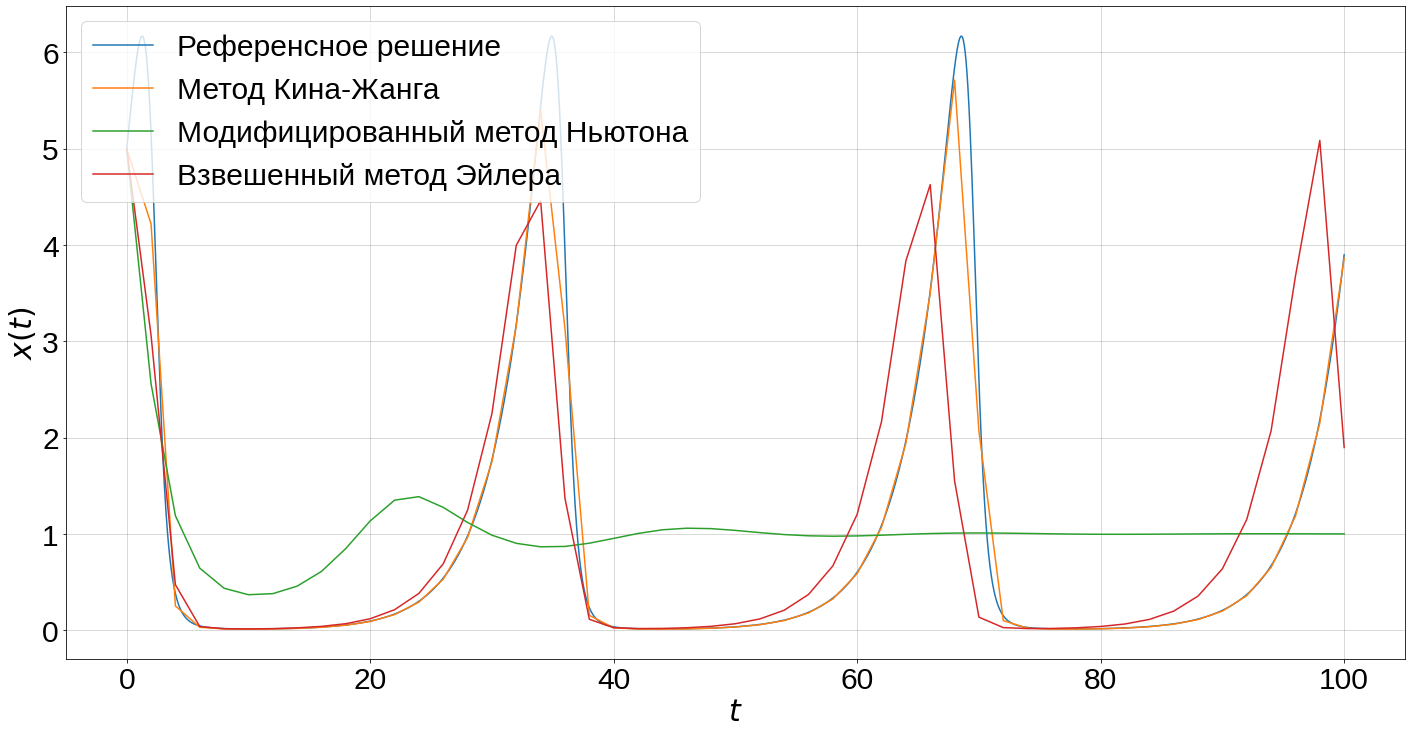

In [34]:
plot_solutions(solutions)

In [35]:
def get_errors(solutions):
    errors = np.zeros(len(solutions))
    
    for n in range(len(solutions)):
        interpolated = np.zeros_like(solutions[n]['values'])
        for index in range(solutions[0]['values'].shape[1]):
            interpolated[:,index] = np.interp(solutions[n]['time'], solutions[0]['time'], solutions[0]['values'][:,index])
        delta = np.sum((solutions[n]['values'] - interpolated)**2, axis=1)
        
        # Интегрирование по методу трапеций.
        for index in range(len(solutions) - 1):
            errors[n] += (solutions[n]['time'][index + 1] - solutions[n]['time'][index]) * (delta[index] + delta[index+1]) / 2.0
            
    errors = np.sqrt(errors)
        
    return errors

In [36]:
get_errors(solutions)

array([   0.        , 3742.40085618,  987.4911214 ,  623.53291806,
         37.4066207 ,   30.34542343,  130.57435469,   74.14394859])

## Зависимость ошибки от величины шага

In [37]:
plot_loss_ = False

In [38]:
#N_test_list = [100, 150, 200, 300, 400, 500, 750, 1000, 2000, 5000, 10000]
N_test_list = np.ceil(np.logspace(np.log10(500), np.log10(10000), 11))

errors = []
for N_test in N_test_list:
    dt_test = T / N_test
    
    implicit_euler = ImplicitEuler(rhs, dt_test)
    implicit_euler.solve(x_0, T)
    
    bdf2 = BDF2(rhs, dt_test)
    bdf2.solve(x_0, T)
    
    trapezoid = Trapezoid(rhs, dt_test)
    trapezoid.solve(x_0, T)
    
    weighted_euler = WeightedEuler(rhs, dt_test)
    weighted_euler.solve(x_0, T)
    
    theta_PareschiRusso = 1 - np.sqrt(2) / 2.0
    A_PareschiRusso = np.array([[theta_PareschiRusso, 0.0],[1 - 2.0 * theta_PareschiRusso, theta_PareschiRusso]])
    b_PareschiRusso = np.array([0.5, 0.5])
    L_pareschi_russo = DIRK(rhs, dt_test, A_PareschiRusso, b_PareschiRusso)
    L_pareschi_russo.solve(x_0, T)
    
    theta_PareschiRusso = 0.25
    A_PareschiRusso = np.array([[theta_PareschiRusso, 0.0],[1 - 2.0 * theta_PareschiRusso, theta_PareschiRusso]])
    b_PareschiRusso = np.array([0.5, 0.5])
    qin_zhang = DIRK(rhs, dt_test, A_PareschiRusso, b_PareschiRusso)
    qin_zhang.solve(x_0, T)
    
    solutions = [
        {'time': reference.T,
         'values': reference.X,
         'N_iters': reference.N_iters,
         'label': 'Референсное решение',
         'tag': 'reference'},

        {'time': implicit_euler.T,
         'values': implicit_euler.X,
         'N_iters': implicit_euler.N_iters,
         'label': 'Неявный метод Эйлера',
         'tag': 'implicit_euler'},

        {'time': bdf2.T,
         'values': bdf2.X,
         'N_iters': bdf2.N_iters,
         'label': 'Формула дифференцирования назад',
         'tag': 'bdf2'},

        {'time': trapezoid.T,
         'values': trapezoid.X,
         'N_iters': trapezoid.N_iters,
         'label': 'Метод трапеций',
         'tag': 'trapezoid'},

        {'time': L_pareschi_russo.T,
         'values': L_pareschi_russo.X,
         'N_iters': L_pareschi_russo.N_iters,
         'label': 'L-устойчивый метод Паречи-Руссо',
         'tag': 'L_pareschi_russo'},

        {'time': qin_zhang.T,
         'values': qin_zhang.X,
         'N_iters': qin_zhang.N_iters,
         'label': 'Метод Кина-Жанга',
         'tag': 'qin_zhang'},

        {'time': weighted_euler.T,
         'values': weighted_euler.X,
         'N_iters': weighted_euler.N_iters,
         'label': 'Взвешенный метод Эйлера',
         'tag': 'weighted_euler'}
    ]
    
    errors.append(get_errors(solutions))

In [39]:
def plot_errors(solutions, errors, N_test_list):
    fig, ax = plt.subplots()

    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

    ax.set_xlabel("$N$")
    ax.set_ylabel("Среднеквадратическое отклонение")
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    for solution_index in range(1, len(solutions)):
        ax.plot(N_test_list, errors[:,solution_index], label=solutions[solution_index]['label'])
        
    ax.legend(loc='lower left')
    plt.show();

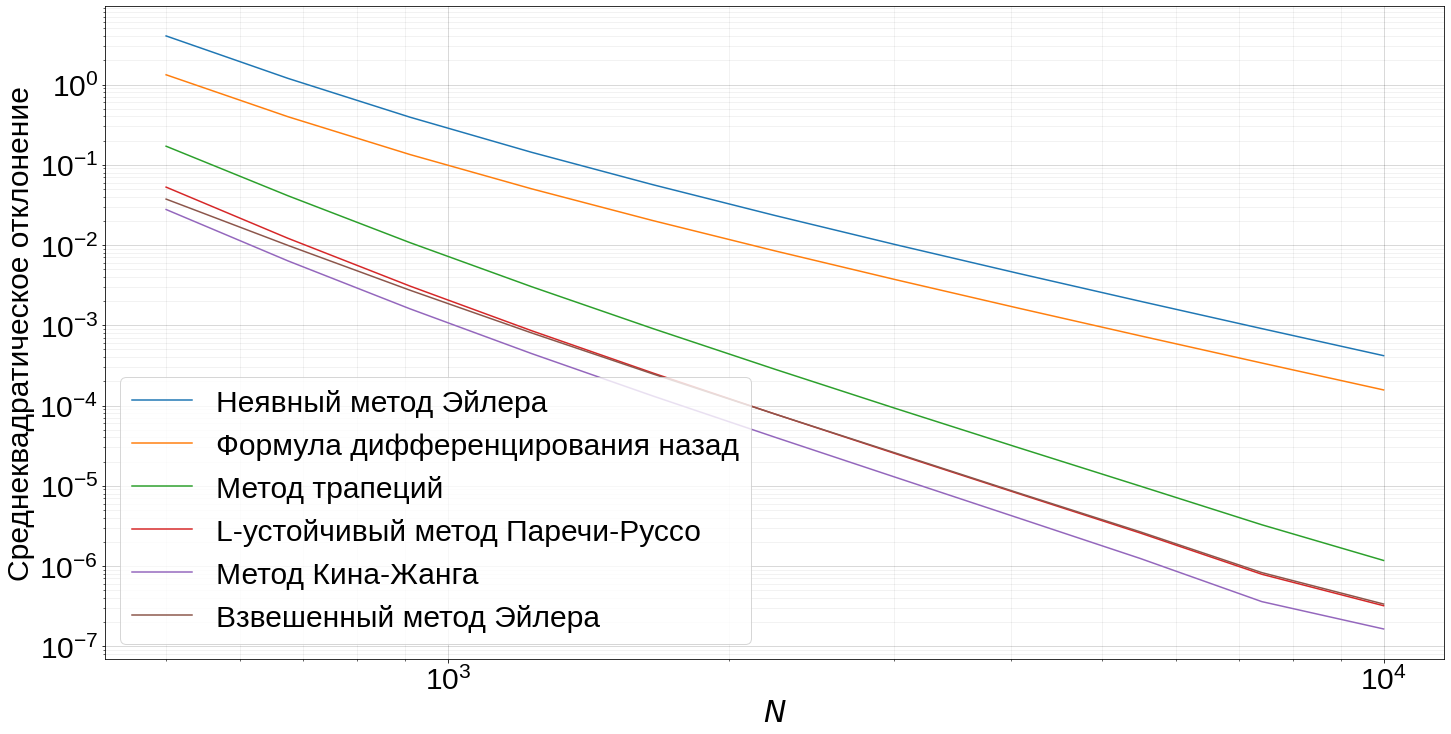

In [40]:
plot_errors(solutions, np.array(errors), N_test_list)